In [1]:
import numpy.random as rand
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

По условию $N_t-N_s$ независима с $N_s$, поэтому

$E(N_t-N_s|N_s) = E(N_t|N_S) - N_s = E(N_t-N_s)$, откуда

$E(N_t|N_S) = E(N_t-N_s) + N_s$

Известно, что

$N_t-N_s \sim Pois(\frac{1}{\lambda}(t-s))$, следовательно

$E(N_t-N_s) = \frac{1}{\lambda}(t-s)$, значит, окончательно имеем:

$E(N_t|N_S) = \frac{1}{\lambda}(t-s) + N_s$

In [2]:
# Получаем данные из файла

with open("6.csv") as file:
    index = 0
    data = []
    for line in file:
        if index == 0:
            poissonLambda = int(line[9:])
        elif index == 1:
            t0 = int(line[5:])
        elif index == 2:
            t = int(line[4:])
        else:
            data.append(float(line))
        index += 1

Считаем, что $\lambda$ распределена по экспоненциальному закону. Сопряженным распределением для него является $\Gamma(\alpha, \beta)$. Апостреорное распределение в таком случае это $\Gamma(\alpha+n,\beta+\sum_{i=1}^{n}X_i)$. Байесовская оценка параметра $\lambda$ - $\frac{\beta+\sum_{i=1}^{n}X_i}{\alpha+n}$

In [3]:
N = 205 # 205 значений k можно взять, пока мы не превысим t
alpha, beta = 1, 1

#E = [1 / poissonLambda * (t - k * t0) + len([value for value in data if value <= k * t0]) for k in range(1, N + 1)]

In [4]:
class Event:
    def __init__(self, type, time):
        self.type = type
        self.time = time

    def __lt__(self, other):
        return self.time < other.time

In [5]:
events = [Event("break", time) for time in data] + [Event("timeout", k * t0) for k in range(N)]
events.sort()

In [8]:
currentBreaks, E, newE, poissonLambdas = [], [], [], []
k = 0
for event in events:
    if event.type == "break":
        currentBreaks.append(event.time)
    else:
        k += 1
        newLambda = (beta + np.sum(currentBreaks)) / (alpha + len(currentBreaks))
        poissonLambdas.append(newLambda)
        E.append(1 / poissonLambda * (t - k * t0) + len(currentBreaks))
        newE.append(1 / newLambda * (t - k * t0) + len(currentBreaks))

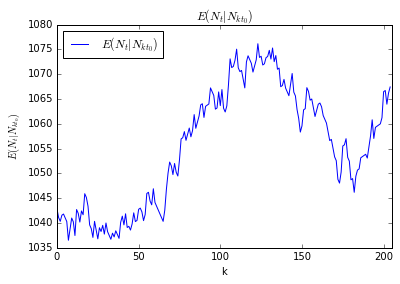

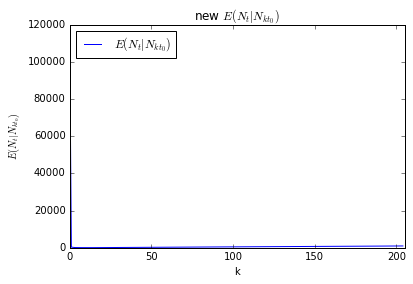

In [10]:
# Строим график

myFigure, myAxis = plt.subplots()
myAxis.plot (range(N), E, label=r"$E(N_t|N_{kt_0})$")
myAxis.legend(loc="upper left")
myAxis.set_xlabel("k")
myAxis.set_ylabel(r"$E(N_t|N_{kt_0})$")
myAxis.set_xlim(0, N)
myAxis.set_title(r"$E(N_t|N_{kt_0})$")

myFigure, myAxis = plt.subplots()
myAxis.plot (range(N), newE, label=r"$E(N_t|N_{kt_0})$")
myAxis.legend(loc="upper left")
myAxis.set_xlabel("k")
myAxis.set_ylabel(r"$E(N_t|N_{kt_0})$")
myAxis.set_xlim(0, N)
myAxis.set_title(r"new $E(N_t|N_{kt_0})$")

Бегает, прыгает, забавно. Казалось бы, в хорошем мире, при большом кол-ве данных точность должна возрастать, должны проявляться какие-нибудь закономерности, например может появляться стремление к какому-нибудь значению. Этого не видно =( Надо заметить, значений k мы имеем воможность взять не так уж и много, это можно считать объяснением.